In [3]:
!pip uninstall rtree -y
!pip install rtree
!pip install trimesh
import numpy as np

Found existing installation: Rtree 1.1.0
Uninstalling Rtree-1.1.0:
  Successfully uninstalled Rtree-1.1.0
  Obtaining dependency information for rtree from https://files.pythonhosted.org/packages/f2/04/74f48b042aabdafa122289957240f4c013aec8c9045c3ce2fe3d1fa7a937/Rtree-1.1.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 7.3 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
  Obtaining dependency information for trimesh from https://files.pythonhosted.org/packages/d8/57/1a2ed89ec937da28d801a818e668cc88620d60205ab132aaa12348767e1c/trimesh-4.0.8-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.9/688.9 kB 12.5 MB/s eta 0:00:00a 0:00:01


In [4]:
file_path = '/kaggle/input/meshes2/test_task_meshes'

In [5]:
import trimesh
import numpy as np
import os
from scipy.spatial import cKDTree

In [6]:
import trimesh
import numpy as np
import os

def preprocess_mesh(mesh_path, num_surface_points=1024, num_volume_points=1024):
    mesh = trimesh.load(mesh_path)
    mesh.apply_translation(-mesh.centroid)
    scale_factor = max(mesh.extents)
    mesh.apply_scale(1 / scale_factor)

    surface_points, _ = trimesh.sample.sample_surface(mesh, num_surface_points)
    min_corner, max_corner = mesh.bounding_box.vertices.min(axis=0), mesh.bounding_box.vertices.max(axis=0)
    volume_points = np.random.rand(num_volume_points, 3) * (max_corner - min_corner) + min_corner
    
    volume_distances = trimesh.proximity.signed_distance(mesh, volume_points)


    # Combine surface and volume points
    all_points = np.vstack([surface_points, volume_points])
    all_distances = np.hstack([np.zeros(num_surface_points), volume_distances]) 
    return mesh, all_points, all_distances

processed_data = []

filename = os.listdir(file_path)[0]
if filename.endswith('.obj'):
    mesh_path = os.path.join(file_path, filename)
    print(mesh_path)
    mesh, points, distances = preprocess_mesh(mesh_path)
    processed_data.append((points, distances))


/kaggle/input/meshes2/test_task_meshes/5.obj


/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:643: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:543: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:546: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 * dot02) * inverse_denominator
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:547: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 * dot12) * inverse_denominator


In [8]:
inside_points = points[distances < 0]
outside_points = points[distances > 0]

In [ ]:
for element in processed_data:
    for ind in range(len(processed_data[1])):
        if processed_data[1][ind] > 0:
            processed_data[1][ind] = 1
        elif processed_data[1][ind] < 0:
             processed_data[1][ind] = -1
        else:
             processed_data[1][ind] = 0
    

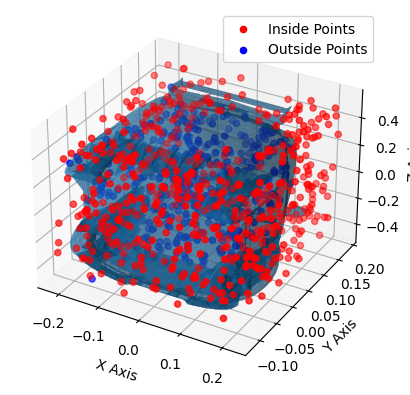

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh
ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, mesh.vertices[:, 2], alpha=0.5)

# Plot inside points in red
ax.scatter(inside_points[:, 0], inside_points[:, 1], inside_points[:, 2], color='red', label='Inside Points')

# Plot outside points in blue
ax.scatter(outside_points[:, 0], outside_points[:, 1], outside_points[:, 2], color='blue', label='Outside Points')

# Setting labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.legend()

plt.show()


In [20]:
# inside_point_cloud = trimesh.points.PointCloud(inside_points, color=[1, 0, 0, 1])  # Red
# outside_point_cloud = trimesh.points.PointCloud(outside_points, color=[0, 0, 1, 1])  # Blue
# scene = trimesh.Scene([mesh, inside_point_cloud, outside_point_cloud])
inside_color = [255, 0, 0, 255]  # Red color in RGBA
outside_color = [0, 0, 255, 255]  # Blue color in RGBA

# Create a PointCloud object for the inside and outside points
inside_point_cloud = trimesh.points.PointCloud(inside_points, colors=inside_color)
outside_point_cloud = trimesh.points.PointCloud(outside_points, colors=outside_color)

# Combine mesh and point clouds for visualization
scene = trimesh.Scene([mesh, inside_point_cloud, outside_point_cloud])

# Set the initial camera zoom so that points can be better seen
scene.camera.zoom = 0.5

# Now show the scene
scene.show()
# scene.show()


In [41]:
inside_color = [1, 0, 0, 1]  # Red color in RGBA
outside_color = [0, 0, 1, 1]  # Blue color in RGBA
point_radius = 0.005  # Adjust the radius of the spheres for visibility


def create_colored_spheres(points, radius, color):
    spheres = [trimesh.creation.icosphere(subdivisions=2, radius=radius) for _ in points]
    for sphere, point in zip(spheres, points):
        sphere.apply_translation(point)
        sphere.visual.vertex_colors = color
    return spheres

# Create colored spheres for inside and outside points
inside_spheres = create_colored_spheres(inside_points, point_radius, np.array(inside_color) * 255)
outside_spheres = create_colored_spheres(outside_points, point_radius, np.array(outside_color) * 255)

# Combine mesh and spheres for visualization
scene = trimesh.Scene([mesh] + inside_spheres + outside_spheres)

# Now show the scene
scene.show()

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Custom Dataset class
class MeshDataset(Dataset):
    def __init__(self, data_list):
        """
        data_list: List of tuples, where each tuple contains points and corresponding distances
        """
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        points, distances = self.data_list[idx]

        # Convert numpy arrays to PyTorch tensors
        points_tensor = torch.tensor(points, dtype=torch.float32)
        distances_tensor = torch.tensor(distances, dtype=torch.float32)

        return points_tensor, distances_tensor

dataset = MeshDataset(processed_data)

batch_size = 32 
shuffle = True  # Shuffle the data each epoch
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [11]:
import torch
import torch.nn as nn

class UDFNet(nn.Module):
    def __init__(self):
        super(UDFNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)

criterion = nn.MSELoss()
model = UDFNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
def train(model, data_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for points, true_distances in data_loader:
            optimizer.zero_grad()

            predictions = model(points)

            loss = criterion(predictions.squeeze(), true_distances)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch}/{epochs} - Loss: {running_loss/len(data_loader)}")
    torch.save(model.state_dict(), 'model2.pth')
    return model

epochs = 100

model = train(model, dataloader, criterion, optimizer, epochs)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2048])) that is different to the input size (torch.Size([2048])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0/100 - Loss: 0.0010592569597065449
Epoch 1/100 - Loss: 0.0010585896670818329
Epoch 2/100 - Loss: 0.0010585896670818329
Epoch 3/100 - Loss: 0.0010585896670818329
Epoch 4/100 - Loss: 0.0010585896670818329
Epoch 5/100 - Loss: 0.0010585896670818329
Epoch 6/100 - Loss: 0.0010585896670818329
Epoch 7/100 - Loss: 0.0010585896670818329
Epoch 8/100 - Loss: 0.0010585896670818329
Epoch 9/100 - Loss: 0.0010585896670818329
Epoch 10/100 - Loss: 0.0010585896670818329
Epoch 11/100 - Loss: 0.0010585896670818329
Epoch 12/100 - Loss: 0.0010585896670818329
Epoch 13/100 - Loss: 0.0010585896670818329
Epoch 14/100 - Loss: 0.0010585896670818329
Epoch 15/100 - Loss: 0.0010585896670818329
Epoch 16/100 - Loss: 0.0010585896670818329
Epoch 17/100 - Loss: 0.0010585896670818329
Epoch 18/100 - Loss: 0.0010585896670818329
Epoch 19/100 - Loss: 0.0010585896670818329
Epoch 20/100 - Loss: 0.0010585896670818329
Epoch 21/100 - Loss: 0.0010585896670818329
Epoch 22/100 - Loss: 0.0010585896670818329
Epoch 23/100 - Loss: 

In [15]:
file_path = '/kaggle/input/models'
points = np.load(f'{file_path}/points.npy')
distances = np.load('/kaggle/input/models2/distances.npy')

In [16]:
import torch
model = torch.load(f'{file_path}/model1.pth')

In [17]:
model.eval()

UDFNet(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): ReLU()
  )
)

In [21]:
points.shape

(50, 50000, 3)

In [44]:
real_distances_tensor.shape

torch.Size([50, 50000])

In [20]:
def calculate_sign_based_f1_score(predicted, actual):
    tp = 0
    fp = 0
    fn = 0
    
    for pred, real in zip(predicted, actual):
        if np.sign(pred) == np.sign(real):
            tp += 1
        else:
            if np.sign(pred) == 0 or np.sign(real) == 0:
                fn += 1
            else:
                fp += 1
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1_score

In [ ]:
def calculate_sign_based_f1_score(predicted, actual):
    predicted_signs = torch.sign(predicted)
    actual_signs = torch.sign(actual)

    TP = torch.sum((predicted_signs == actual_signs))
    FP = torch.sum((predicted_signs != actual_signs) & (predicted_signs != 0))
    FN = torch.sum((predicted_signs != actual_signs) & (actual_signs != 0))

    TP = TP.float()
    FP = FP.float()
    FN = FN.float()

    precision = TP / (TP + FP) if TP + FP > 0 else torch.tensor(0.0)
    recall = TP / (TP + FN) if TP + FN > 0 else torch.tensor(0.0)

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else torch.tensor(0.0)

    return f1_score.item()

f1_score = calculate_sign_based_f1_score(predicted_distances_flat, real_distances_flat)

print(f"F1 Score: {f1_score}")


In [22]:
import trimesh
import numpy as np

def generate_surface_points_with_noise(mesh, num_points, std=1e-2):
    surface_points, _ = trimesh.sample.sample_surface(mesh, num_points)
    noise = np.random.normal(scale=std, size=surface_points.shape)
    return surface_points + noise

def generate_volume_points(mesh, num_points):
    min_corner, max_corner = mesh.bounding_box.vertices.min(axis=0), mesh.bounding_box.vertices.max(axis=0)
    return np.random.rand(num_points, 3) * (max_corner - min_corner) + min_corner

mesh = trimesh.load('/kaggle/input/meshes2/test_task_meshes/0.obj')

num_points = 50000 
surface_points = generate_surface_points_with_noise(mesh, num_points)
volume_points = generate_volume_points(mesh, num_points)



In [71]:
def get_labels(points, actual_distances, threshold=0):
    """
    Determine whether each point is inside or outside the object.
    
    Args:
    - points (numpy.ndarray): The points to label.
    - actual_distances (numpy.ndarray): The actual signed distances for these points.
    - threshold (float): The threshold to determine if a point is inside or outside.

    Returns:
    - numpy.ndarray: An array of labels (True for inside, False for outside).
    """
    # Points with a distance less than or equal to the threshold are inside
    return actual_distances <= threshold


In [ ]:
import torch
from sklearn.metrics import precision_recall_fscore_support

def calculate_f1_scores(model, surface_points, volume_points, threshold=0):
    surface_points_tensor = torch.tensor(surface_points, dtype=torch.float32)
    volume_points_tensor = torch.tensor(volume_points, dtype=torch.float32)

    if next(model.parameters()).is_cuda:
        surface_points_tensor = surface_points_tensor.to('cuda')
        volume_points_tensor = volume_points_tensor.to('cuda')

    model.eval()
    with torch.no_grad():
        # Predict occupancy for surface points
        surface_predictions = model(surface_points_tensor) < threshold
        surface_labels = get_labels(surface_points)  # True if inside, False if outside

        precision, recall, f1_surface, _ = precision_recall_fscore_support(surface_labels, surface_predictions.cpu().numpy(), average='binary')
        volume_predictions = model(volume_points_tensor) < threshold
        volume_labels = get_labels(volume_points)

        _, _, f1_volume, _ = precision_recall_fscore_support(volume_labels, volume_predictions.cpu().numpy(), average='binary')

    return f1_surface, f1_volume

calculate_f1_scores(model,surface_points, volume_points)
